<a href="https://colab.research.google.com/github/zcwisc/GB657/blob/main/Module_5_TextClassExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification via LSTM and BERT


In this tutorial, we go through a text classification example to see how text data can be used in ML applications. We rely on (a sllightly reduced version of) the AG News Classification Dataset, which contains news articles, their titles, and what type of article it is (class ids 1-4 where 1-World, 2-Sports, 3-Business, 4-Sci/Tech).

We use a LSTM network, BERT with and without fine tuning.

As usually, let's start with loading the relevant libaries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D

And let's import the dataset:

In [ ]:
!git clone https://github.com/zcwisc/GB657.git

Cloning into 'GB657'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 77 (delta 32), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 28.75 MiB | 6.65 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [ ]:
News = pd.read_csv('GB657/Module_5_TextClassExample.csv', index_col=0)

In [ ]:
News.head()

# Prepare and Clean the Data

We start by preparing the text data.

We first reset the "Index" (because the first column really is a category), coerce it to be between 0 and 3, and make it a class variable:

In [ ]:
News = News.reset_index()
News = News.rename(columns={"Class Index": "Category"})
News['Category'] = News['Category'] - 1
News.head()

Then, let's again combine the Title and Description columns:

In [ ]:
News['Combined'] = News['Title'] + ' ' + News['Description']
News = News.drop(['Title', 'Description'], axis=1)
News.head()

In [ ]:
X = News['Combined']
y = News['Category']

We carry out two data processing steps: **Tokenization** and **Padding**


* **Tokenization** is common in Natural Language Processing (NLP). Essentially, we take big or combined words and separate them into pieces called **tokens**. Often tokens correspond to full words, but it can also correspond to subwords (e.g., removing "-er" in "faster" or "-ly" in "quickly"). Tokens are then often assigned a number so that we can represent a text fragment as a sequence of numbers corresponding to tokens.

* ML models require inputs that have the same shape and size. However, not all the news articles have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the **padding** is necessary. To make them the same size, we pad shorter sequences with a special token (often 0 or Null) until they reach the chosen maximum length.


We use a tokenizer from Keras:

In [ ]:
vocab_size = 10000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

# Create and Fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X.values)

The Tokenizer now has tokens in it and gives each of them a number:

In [ ]:
tok.word_index

{'the': 1,
 'to': 2,
 'a': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 '39': 9,
 's': 10,
 'that': 11,
 'with': 12,
 'as': 13,
 'at': 14,
 'its': 15,
 'is': 16,
 'new': 17,
 'by': 18,
 'said': 19,
 'it': 20,
 'reuters': 21,
 'has': 22,
 'from': 23,
 'an': 24,
 'ap': 25,
 'his': 26,
 'will': 27,
 'after': 28,
 'was': 29,
 'gt': 30,
 'lt': 31,
 'us': 32,
 'be': 33,
 'over': 34,
 'have': 35,
 'up': 36,
 'their': 37,
 'two': 38,
 'first': 39,
 'are': 40,
 'quot': 41,
 'year': 42,
 'but': 43,
 'more': 44,
 'he': 45,
 'u': 46,
 '1': 47,
 'this': 48,
 'one': 49,
 'world': 50,
 'oil': 51,
 'monday': 52,
 'out': 53,
 'wednesday': 54,
 'tuesday': 55,
 'thursday': 56,
 'company': 57,
 'not': 58,
 '2': 59,
 'against': 60,
 'inc': 61,
 'friday': 62,
 'than': 63,
 'into': 64,
 'last': 65,
 'about': 66,
 'b': 67,
 'they': 68,
 'york': 69,
 'who': 70,
 'three': 71,
 'yesterday': 72,
 'no': 73,
 'president': 74,
 'iraq': 75,
 'million': 76,
 'were': 77,
 'game': 78,
 'microsoft': 79,
 'been

We can now convert the text sequence to numbers. Note that they have speficic meaning based on the initialization:

In [ ]:
X = tok.texts_to_sequences(X)

Let's look at the first element:

In [ ]:
X[0]

[215,
 1048,
 7763,
 5,
 105,
 368,
 4,
 4172,
 394,
 5,
 2035,
 938,
 62,
 12,
 1,
 46,
 10,
 2171,
 161,
 8,
 1,
 2171,
 4,
 1835,
 215,
 2221,
 1,
 7763,
 4,
 3,
 201,
 5274,
 4,
 1,
 999,
 938,
 60,
 20,
 65,
 42,
 18,
 1,
 4172,
 99]

Look above: The fourth word is "in" which has token number 5. The seventh word is "of" which has token number 4.

Let's check how long the sequences are:

In [ ]:
max_len = 0
max_len_index = 0

for i, seq in enumerate(X):
  if len(seq) > max_len:
    max_len = len(seq)
    max_len_index = i

print(f"The vector with the most elements is at index {max_len_index} with {max_len} elements.")

The vector with the most elements is at index 24253 with 174 elements.


In [ ]:
X = pad_sequences(X, maxlen=max_len)

So now X contains sequences that all have the same fixed length. Each number in these sequences is a token ID — an integer that represents a specific word in the vocabulary. But these token IDs themselves do not carry meaning.
For example, token 37 and token 1258 do not tell us anything about whether their words are similar or related. They are just index numbers.

To give these tokens useful meaning, we will pass them through an embedding layer, which maps each token ID to a dense vector (a list of numbers). These vectors capture relationships between words — for example, similar words end up with similar vectors.

This way, the model does not work with raw token IDs, but with learned word representations that contain semantic information.

# ML Modeling - LSTM

So let's do some ML. We start by splitting our data into a training and test set

In [ ]:
y = to_categorical(y,4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

To "learn" the relevance of tokens in sequence (and, e.g., whether the "international" aspects of a story or the "sports" aspects of a story dominate), we can rely on an RNN. We will use a LSTM. Our design is as follows:

* We use an [*Embedding*](https://keras.io/api/layers/core_layers/embedding/) layer that maps the tokenized input (so each word, kind of) to a vector of size 32 (as defined by `embed_size`). The input_dim is set to 10,000, which is the size of our vocabulary.
* Two LSTM Layers.
* A pooling Layer in the LSTM output decreases sensitivity to features, thereby creating more generalised data for better test results.
* Dropout layer nullifies certain random input values to generate a more general dataset and prevent overfitting.
* As before, a softmax output layer.

Let's try:

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim=embed_size,input_length=10,input_shape=(max_len,)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D()) #
model.add(Dense(64))
model.add(Dropout(0.25)) #
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 174, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 174, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 174, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,212 (1.75 MB)

 Trainable params: 458,212 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

So, we have a high-dimensional model. Let's see how well it performs.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU detected:", gpus)
else:
    print("No GPU detected, using CPU.")


GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

if tf.config.list_physical_devices('GPU'):
    with tf.device('/GPU:0'):
        history = model.fit(
            X_train,
            y_train,
            batch_size=256,
            validation_data=(X_test, y_test),
            epochs=20,
            callbacks=[early_stop]
        )
else:
    history = model.fit(
        X_train,
        y_train,
        batch_size=256,
        validation_data=(X_test, y_test),
        epochs=20,
        callbacks=[early_stop]
    )


Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6211 - loss: 0.8413 - val_accuracy: 0.8962 - val_loss: 0.3176
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9172 - loss: 0.2608 - val_accuracy: 0.9038 - val_loss: 0.2823
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9348 - loss: 0.2081 - val_accuracy: 0.9053 - val_loss: 0.2853


Let's again check the performance:

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


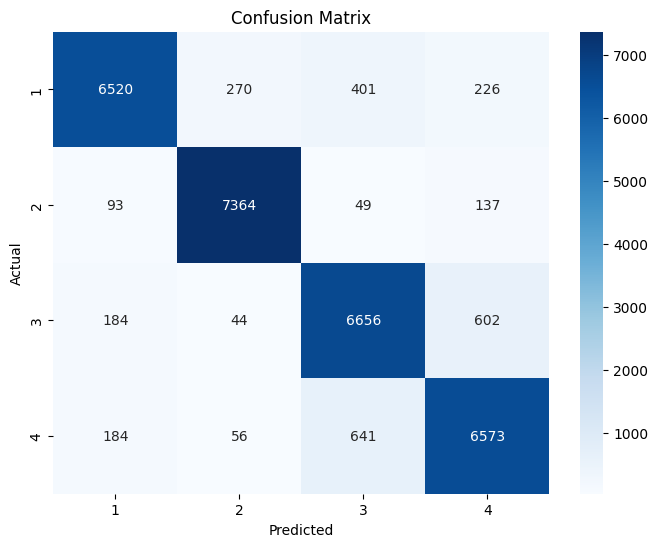

Accuracy: 0.9037666666666667


In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# BERT without fine-tuning

Using BERT as a Feature Extractor (No Fine-Tuning). We are not training BERT and we are not updating any of its weights.



1.   Feed each news article into a pretrained BERT model.
2.   Extract the embedding (vector) corresponding to the [CLS] token.
3.   Use that vector as the representation of the whole text.
4.   Train a simple classifier (e.g., logistic regression, small neural net) on top of those vectors.

So BERT becomes a feature generator, like a very powerful universal text encoder.


What Is the [CLS] Token?

[CLS]  token1  token2  token3  ...  tokenN  [SEP]

It is not a real word; it is a special placeholder token. During BERT pretraining, the model learns to pack information about the entire sequence into the hidden state of the [CLS] token. Think of it as "A summary vector of the whole sentence/document."

It is NOT just the average of all token embeddings.








To use pretrained transformer-based models, we rely on the platform called Hugging Face (https://huggingface.co/docs/transformers/index)




*   A widely used open-source platform that provides pretrained Transformer models (BERT, GPT, T5, etc.).
*   Makes it very easy to load, run, and fine-tune modern NLP models without building everything from scratch.







In [ ]:
X = News['Combined']
y = News['Category']
y = to_categorical(y,4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

First, we get embeddings from BERT

In [ ]:
!pip install -q transformers datasets

from transformers import pipeline, BertTokenizer, BertModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

def get_cls_embedding(text):
    encoded = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=128,
        # this does not have to be 128, in Keras tokenizer, we see max length as 174
        # A little truncation usually does not change the prediction much
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        output = bert(**encoded)

    # CLS token embedding
    cls_vec = output.last_hidden_state[:, 0, :].cpu().numpy()
    return cls_vec


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Build dataset of [CLS] embeddings

In [ ]:
from tqdm import tqdm # this is just for keeping track of the process

# Convert training texts into CLS embeddings
X_train_embeddings = []

print("Encoding training set...")
for text in tqdm(X_train, total=len(X_train)):
    vec = get_cls_embedding(text)
    X_train_embeddings.append(vec)

X_train_embeddings = np.vstack(X_train_embeddings)


# Convert test texts into CLS embeddings
X_test_embeddings = []

print("Encoding test set...")
for text in tqdm(X_test, total=len(X_test)):
    vec = get_cls_embedding(text)
    X_test_embeddings.append(vec)

X_test_embeddings = np.vstack(X_test_embeddings)

print("Shapes:", X_train_embeddings.shape, X_test_embeddings.shape)


Encoding training set...


100%|██████████| 70000/70000 [10:59<00:00, 106.08it/s]


Encoding test set...


100%|██████████| 30000/30000 [04:37<00:00, 108.24it/s]

Shapes: (70000, 768) (30000, 768)


Train a simple logistics regression for final classification task, based on the BERT [CLS] embeddings

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=2000)
y_train = np.argmax(y_train, axis=1)
y_test  = np.argmax(y_test, axis=1)
clf.fit(X_train_embeddings, y_train)

y_pred = clf.predict(X_test_embeddings)
# acc = accuracy_score(y_test, y_pred)
# print(f"Test accuracy (BERT + Logistic Regression): {acc:.4f}")

# cm = confusion_matrix(y_test, y_pred)
# print("Confusion matrix:\n", cm)

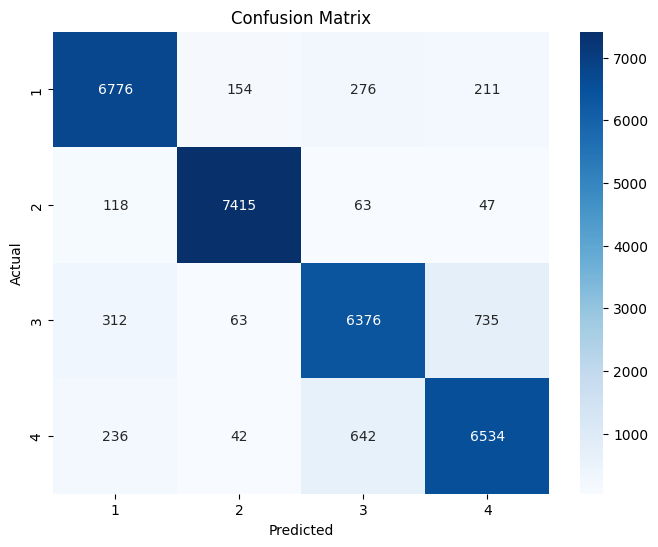

Accuracy: 0.9033666666666667


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# BERT with fine tuning

When we fine-tune BERT, we allow all of BERT’s weights to update based on our specific classification task. This makes BERT specialize to our dataset rather than acting as a generic text encoder.

What Happens in Fine-Tuning?

1. Start with a pretrained BERT model
The model already understands grammar, meaning, relationships between words, etc.

2. Add a small classification layer on top
For example, a dense layer that maps BERT’s [CLS] embedding → 4 news categories.

3. Feed each news article through the entire model (BERT + classifier)
The [CLS] token again acts as the “summary vector,” but now it is optimized for our task.

4. Train the whole model end-to-end
    *   The classifier layer learns how to map BERT’s output to our categories.
    *   The internal BERT layers adjust slightly so that the [CLS] representation becomes more useful for our specific dataset.
    *   This is why fine-tuning usually gives much better results.

So BERT becomes not just a feature extractor, but a full classifier adapted to our task.







Working with Hugging Face, we also don't need to write the code for fine-tuning from scratch. Hugging Face Trainer is a flexible training framework for fine-tuning Transformers on our own dataset (https://huggingface.co/docs/transformers/main_classes/trainer).

First, we prepare the data. Hugging Face tools (tokenizers, data collators, Trainer, etc.) are designed to work with their own Dataset format.

In [ ]:
from datasets import Dataset

X = News['Combined']
y = News['Category']
y = to_categorical(y,4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_df = pd.DataFrame({"text": X_train, "label": np.argmax(y_train, axis=1)})
test_df  = pd.DataFrame({"text": X_test,  "label": np.argmax(y_test, axis=1)})

train_ds = Dataset.from_pandas(train_df)
test_ds  = Dataset.from_pandas(test_df)

In [ ]:
from transformers import BertTokenizerFast
# we use a faster model

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
        # this does not have to be 128, in Keras tokenizer, we see max length as 174
        # A little truncation usually does not change the prediction much
    )

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

train_ds = train_ds.remove_columns(["text"])
test_ds  = test_ds.remove_columns(["text"])

train_ds.set_format("torch")
test_ds.set_format("torch")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

*BertForSequenceClassification* loads a BERT model that has an extra classification layer added on top.
When we call *from_pretrained("bert-base-uncased", num_labels=4)*, we start with a pretrained BERT encoder and initialize a new output layer that will learn to predict one of four categories for our news articles.

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We set up batch size, learning rate, and number of epochs (usually we take 2-5 and rarely more than 10 additional epochs for fine tuning; sometimes 1 epoch is enough).

It also controls where to save the model, when to evaluate, and how often to print training progress

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_finetune",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=2, # additional epochs for fine tuning
    learning_rate=2e-5,
    load_best_model_at_end=True, # it automatically keeps the best-performing version of the model
    report_to="none" # turns off online logging tools, associated with os.environ["WANDB_DISABLED"] = "true" below
)

Now, we are ready to fine-tune the model

In [ ]:
from transformers import Trainer
import os
os.environ["WANDB_DISABLED"] = "true"

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.192400,0.172029
2,0.139100,0.168755


TrainOutput(global_step=2188, training_loss=0.1712962541545331, metrics={'train_runtime': 704.6961, 'train_samples_per_second': 198.667, 'train_steps_per_second': 3.105, 'total_flos': 9209052303360000.0, 'train_loss': 0.1712962541545331, 'epoch': 2.0})

In [ ]:
y_test  = np.argmax(y_test, axis=1)
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)

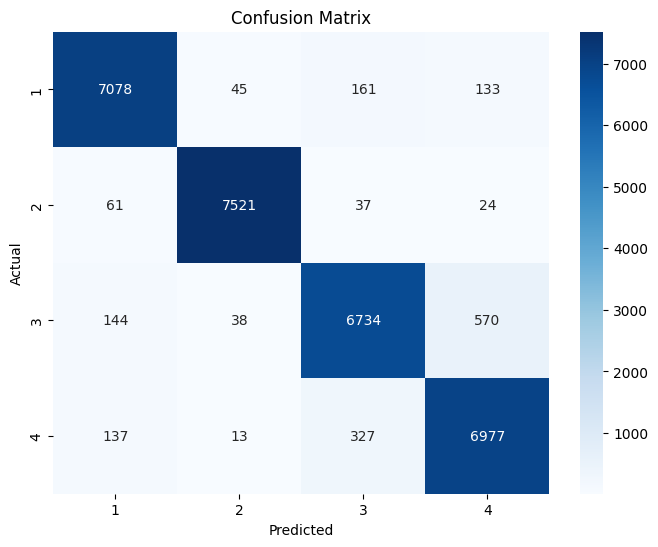

Accuracy: 0.9436666666666667


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")